# Modeling of bike crashes


Different approach : 
- do a model predicting crash based on forecast and binning of space
- make a day by day binary classification
- could we use a point process
- look into poisson arrival time to predict what is the probability of an accident today (or tomorrow)

In [31]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import osmnx as ox
import pickle
import geojson
import dill

# Show all columns
pd.set_option('display.max_columns', None)

# Plot style
plt.rcParams['font.size'] = 12

# Getting the data ready

In [2]:
# Reload all the variables from the other notebook
# dill.load_session('notebook_env.db')

# Unpickle the data
with open('eda_output.dat', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
    masegs = data['masegs']
    geolanes = data['geolanes']
    geocrash = data['geocrash']
    
masegs['ExisFacil'] = masegs['ExisFacil'].cat.add_categories('none').fillna('none')

crash_count = geocrash[geocrash.YEAR == 2018]['masegs_idx'].value_counts()
masegs['crash18'] = 0
masegs.iloc[crash_count.index.astype(int), masegs.columns == 'crash18'] = crash_count.values

crash_count = geocrash[geocrash.YEAR == 2017]['masegs_idx'].value_counts()
masegs['crash17'] = 0
masegs.iloc[crash_count.index.astype(int), masegs.columns == 'crash17'] = crash_count.values

crash_count = geocrash[geocrash.YEAR == 2016]['masegs_idx'].value_counts()
masegs['crash16'] = 0
masegs.iloc[crash_count.index.astype(int), masegs.columns == 'crash16'] = crash_count.values

crash_count = geocrash[geocrash.YEAR == 2015]['masegs_idx'].value_counts()
masegs['crash15'] = 0
masegs.iloc[crash_count.index.astype(int), masegs.columns == 'crash15'] = crash_count.values




In [3]:
len(masegs)

29166

In [4]:
g18 = geocrash[geocrash.YEAR == 2018]
w18 = g18.groupby('masegs_idx')['WEEK'].value_counts()
w18

masegs_idx  WEEK
18.0        39      1
30.0        38      1
35.0        25      1
149.0       24      1
224.0       29      1
267.0       37      1
325.0       29      1
426.0       39      1
465.0       40      1
494.0       39      1
507.0       28      1
626.0       8       1
744.0       27      1
799.0       18      1
958.0       19      1
1121.0      34      1
1197.0      36      1
1413.0      35      1
1548.0      4       1
1596.0      35      1
            44      1
1728.0      23      1
1775.0      41      1
1894.0      42      1
1908.0      8       1
1996.0      43      1
2120.0      23      1
2233.0      45      1
2497.0      36      1
            40      1
                   ..
27816.0     17      1
28038.0     26      1
28107.0     23      1
28143.0     48      1
28201.0     48      1
28237.0     37      1
28241.0     31      2
28286.0     48      1
            49      1
28477.0     36      1
28590.0     33      1
28596.0     37      1
28605.0     30      1
28686.0     24 

In [5]:
display(masegs)
display(geocrash)

,OBJECTID,Route_ID,Rd_Seg_ID,St_Name,Facility,F_F_Class,Num_Lanes,Lt_Sidewlk,Rt_Sidewlk,Operation,Speed_Lim,Struct_Cnd,AADT,Length,ShapeSTLength,geometry,ExisFacil,InstallDat,crash,crash18,crash17,crash16,crash15
0,856,B0240,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.007570,12.183446,(LINESTRING Z (-7911744.563034028 5219242.0688...,none,None,0,0,0,0,0
1,858,B0240,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.022412,36.068115,(LINESTRING Z (-7911756.435968117 5219270.8930...,none,None,0,0,0,0,0
2,860,B0240,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.188590,303.506864,(LINESTRING Z (-7911781.006509871 5219315.2572...,none,None,0,0,0,0,0
3,882,B0246,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.139643,224.733307,(LINESTRING Z (-7902973.948572249 5219910.7520...,none,None,0,0,0,0,0
4,883,B0247,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.082351,132.531124,(LINESTRING Z (-7902973.948572249 5219910.7520...,none,None,0,0,0,0,0
5,884,B0247,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.014675,23.617919,(LINESTRING Z (-7902983.398702456 5219738.1338...,none,None,0,0,0,0,0
6,885,B0247,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.384552,618.877988,(LINESTRING Z (-7902958.934155771 5219717.6914...,none,None,0,0,0,0,0
7,886,B0248,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.010215,16.439283,(LINESTRING Z (-7902983.398702456 5219738.1338...,none,None,0,0,0,0,0
8,887,B0248,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.123708,199.088610,(LINESTRING Z (-7902962.505915821 5219744.9625...,none,None,0,0,0,0,0
9,888,B0248,NaN,None,Bicycle/ Pedestrian,Local,0.0,0.0,0.0,No traffic,30.0,Fair,0.000000,0.008754,14.088433,(LINESTRING Z (-7902726.769965285 5219851.1756...,none,None,0,0,0,0,0


,DATE,YEAR,DAY_WEEK,TIME,ISINTERSEC,geometry,MONTH,masegs_idx,WEEK
0,2009-01-09,2009,Friday,14,1.0,POINT (-7917183.510539606 5213806.049335828),1,29002.0,2
1,2009-01-23,2009,Friday,16,1.0,POINT (-7918979.09338661 5214087.732639168),1,28955.0,4
2,2009-01-25,2009,Sunday,12,0.0,POINT (-7913442.156280413 5210339.438534557),1,14393.0,4
3,2009-02-05,2009,Thursday,5,1.0,POINT (-7906207.412175795 5218329.055240225),2,23067.0,6
4,2009-02-08,2009,Sunday,8,0.0,POINT (-7910665.38230236 5213196.338006518),2,21716.0,6
5,2009-02-09,2009,Monday,23,0.0,POINT (-7917670.212299837 5203970.306442088),2,7382.0,7
6,2009-02-13,2009,Friday,13,0.0,POINT (-7910660.174235678 5214412.612292374),2,18765.0,7
7,2009-02-13,2009,Friday,17,1.0,POINT (-7913603.476843713 5213557.512253662),2,28237.0,7
8,2009-02-19,2009,Thursday,20,0.0,POINT (-7912622.430486054 5213041.146984699),2,28704.0,8
9,2009-02-21,2009,Saturday,13,1.0,POINT (-7912297.699731556 5213562.030957619),2,19394.0,8


Notes:

Here are the features used by the D4D project
- f_cat: width, cycleway_type, signal, oneway, SPEEDLIMIT, Struct_Cnd, Surface_Tp, F_F_Class
- f_cont: lanes, hwy_type, osm_speed, width_per_lane, AADT

,Num_Lanes,Lt_Sidewlk,Rt_Sidewlk,Speed_Lim,AADT,d_Interstate,d_Local,d_Major Collector,d_Minor Arterial,d_Principal Arterial - Other,d_Principal Arterial - Other Freeways or Expressways,d_No traffic,d_One-way traffic,d_Two-way traffic,d_0,d_Deficient,d_Fair,d_Good,d_Intolerable,d_exclusive,d_protected,d_shared,d_none
0,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
2,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
6,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
7,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
8,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
9,0.0,0.000000,0.000000,0.444444,0.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1


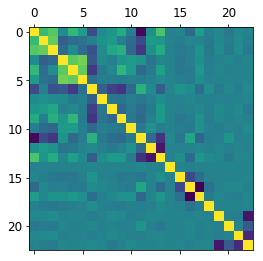

In [61]:
# Select continuous variables
cont = ['Num_Lanes', 'Lt_Sidewlk', 'Rt_Sidewlk', 'Speed_Lim', 'AADT']#, 'crash17', 'crash16', 'crash15']
# cont = ['Num_Lanes', 'Speed_Lim', 'AADT']
# cont = ['crash17', 'crash16', 'crash15','Num_Lanes', 'Speed_Lim', 'AADT']
# Select categorical variables
# cat = ['Facility', 'F_F_Class', 'Operation', 'Struct_Cnd', 'ExisFacil']
cat = ['F_F_Class', 'Operation', 'Struct_Cnd', 'ExisFacil']
# cat = ['F_F_Class']

# Normalize the continuous variables
# feats = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(masegs[cont].values))
feats = masegs[cont] 
feats = (feats - feats.min()) / (feats.max() - feats.min())
feats.fillna(0)
feats = pd.concat([feats, pd.get_dummies(masegs[cat], prefix='d')], axis=1)
# feats = (feats - feats.mean()) / feats.std()
plt.matshow(feats.corr())
display(feats)

# Choosing the variable for regression/classification
y = masegs['crash'].values
X = feats.values

# Turning the outcome into a binary output
yb = np.copy(y)
yb[yb > 0] = 1
Xb = np.copy(X)

(array([26941.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2225.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

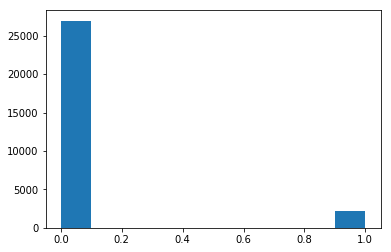

In [22]:
plt.hist(yb)

# Using classifiers

In [60]:
X_train, X_test, y_train, y_test = train_test_split(Xb, yb, test_size=0.20, stratify=yb)
print(np.sum(y_train))

# Trying to deal with imbalance in the data by subsampling the segments with 0 events
sel = y_train == 0
X0 = X_train[sel]
y0 = y_train[sel]
sub = np.random.choice(range(len(y0)), size=2*sum(~sel), replace=False)
X_train = np.concatenate([X_train[~sel,:], X0[sub,:]])
y_train = np.concatenate([y_train[~sel], y0[sub]])

# Oversampling 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(np.sum(y_train))

-25112


ValueError: 'a' cannot be empty unless no samples are taken

(7120, 23)

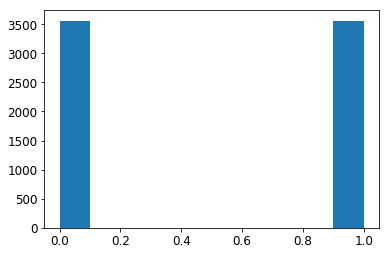

In [50]:
plt.hist(y_train)
X_train.shape

In [51]:
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import recall_score
# dummy = DummyRegressor(strategy='median')
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print(dummy.score(X_test, y_test), recall_score(y_test, dummy.predict(X_test)))

0.9237230030853617 0.0


In [52]:
from sklearn.svm import LinearSVC
clf = LinearSVC() # Uses liblinear as a solver, gets exactly save results as LR
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), recall_score(y_test, clf.predict(X_test)))

0.674322934521769 0.6629213483146067


0.6736372985944463 0.6606741573033708
Index(['d_none', 'd_Interstate', 'd_Intolerable',
       'd_Principal Arterial - Other Freeways or Expressways', 'Speed_Lim',
       'd_Two-way traffic', 'd_Local', 'd_One-way traffic', 'd_Good', 'd_0',
       'd_exclusive', 'd_Fair', 'd_Major Collector', 'AADT', 'd_Deficient',
       'd_No traffic', 'd_protected', 'd_shared', 'Num_Lanes',
       'd_Minor Arterial', 'd_Principal Arterial - Other', 'Lt_Sidewlk',
       'Rt_Sidewlk'],
      dtype='object')
[-0.88142514 -0.67073846 -0.48500949 -0.41197187 -0.31443841 -0.2253773
 -0.2146595  -0.11973749 -0.00683228  0.          0.15400613  0.16333559
  0.20103479  0.20247842  0.21993606  0.23654467  0.29176998  0.3270789
  0.36389032  0.41794223  0.56982269  1.31509217  2.35729891]


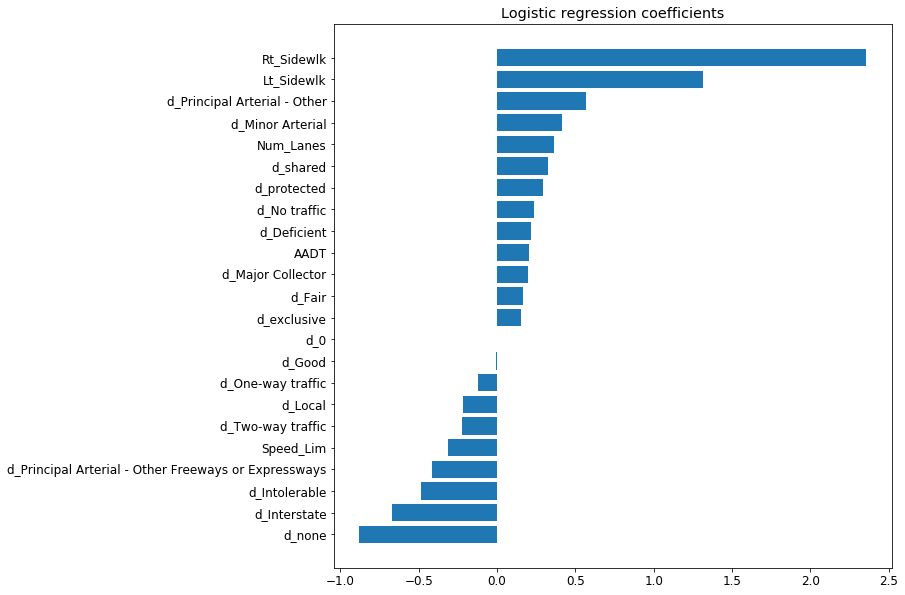

In [59]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# clf = LogisticRegression(solver='lbfgs')
clf = LogisticRegressionCV(cv=5, max_iter=300, solver='liblinear')#, class_weight='balanced')
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), recall_score(y_test, clf.predict(X_test)))

plt.figure(figsize=(10,10))
plt.barh(range(len(clf.coef_[0])),
         width=np.sort(clf.coef_[0]))
plt.yticks(ticks=range(len(clf.coef_[0])), labels=feats.columns[np.argsort(clf.coef_[0])])
plt.title('Logistic regression coefficients')
print(feats.columns[np.argsort(clf.coef_[0])])
print(np.sort(clf.coef_[0]))
plt.savefig("fig/lr_coeff.png", bbox_inches='tight')

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'n_estimators': [4, 8, 16, 32, 64, 100],
    'max_depth': [4, 8, 16, 32],
    'max_features': [4, 5, 6],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': np.linspace(0.2, 1.0, 5, endpoint=True),
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
best_grid
print(best_grid.score(X_test, y_test), recall_score(y_test, best_grid.predict(X_test)))

In [33]:
# Random forest
clf = RandomForestClassifier(n_estimators=100)
# Gradient boosting regression
# clf = GradientBoostingClassifier(n_estimators=200)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test), recall_score(y_test, clf.predict(X_test)))

0.7487144326362701 0.4786516853932584


0.3158587639292882 AADT


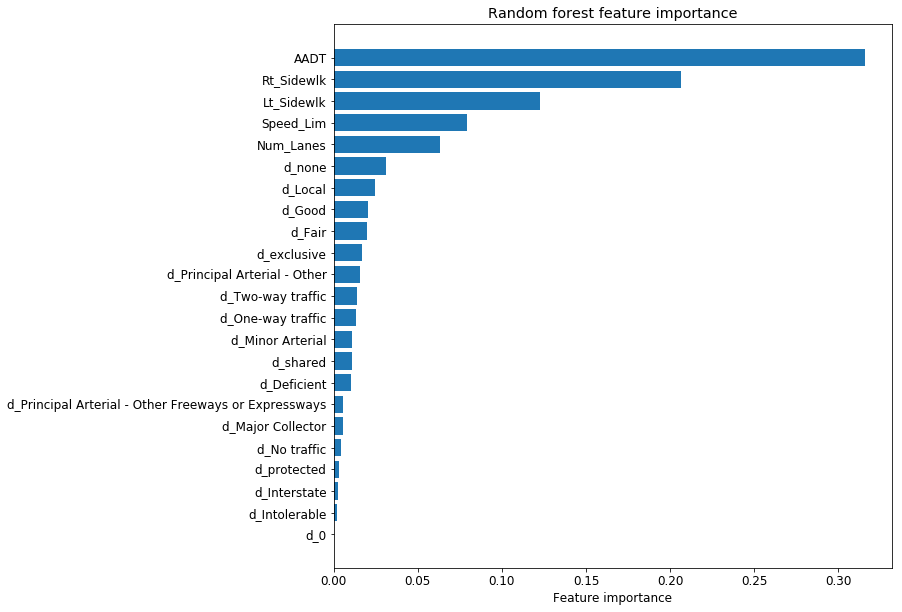

In [35]:
print(max(clf.feature_importances_), feats.columns[np.argmax(clf.feature_importances_)])

feat_imp = pd.DataFrame({
    'Feature': feats.columns[np.argsort(clf.feature_importances_)],
    'Importance': np.sort(clf.feature_importances_)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,10))
plt.barh(y = feat_imp['Feature'], width=feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature importance')
plt.title('Random forest feature importance')
plt.savefig("fig/rf_feat_importance.png", bbox_inches='tight')

In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp

# clf = RandomForestClassifier(n_estimators=100)
# skf = StratifiedKFold(n_splits=5)
# for train_index, test_index in skf.split(Xb, yb):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = Xb[train_index], Xb[test_index]
#     y_train, y_test = yb[train_index], yb[test_index]
#     clf.fit(X_train, y_train)
    

# cv = StratifiedKFold(n_splits=5)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)
classifier = LogisticRegression(solver='liblinear', max_iter=300)
# classifier = RandomForestClassifier(n_estimators=100)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(Xb, yb):
    probas_ = classifier.fit(Xb[train], yb[train]).predict_proba(Xb[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(yb[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.show()
plt.savefig("fig/lr_roc.png", bbox_inches='tight')

# Regression using different approaches

In [ ]:
# Linear regression
model = sm.OLS(y, sm.add_constant(X))
lin_res = model.fit()
lin_res.summary()

In [ ]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson
model = ZeroInflatedPoisson(y, sm.add_constant(X))
poi_res = model.fit()
poi_res.summary()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
# pca.fit(X)
Xpca = pca.fit_transform(X)
Xpca.shape, X.shape
# plt.plot(pca.explained_variance_ratio_)

model = NegativeBinomial(y, Xpca)
poi_res = model.fit()
display(poi_res.summary())

In [ ]:
ypred = poi_res.predict()
plt.hist(np.exp(ypred))

# from scipy import stats
# prob_2more = stats.poisson.sf(2 - 1, ypred)#.mean() # average over x in sample
# freq_2more = (y > 2 - 1).mean()  # sample average
# prob_2_obs = stats.poisson.pmf(2, ypred)
# freq_2more
# plt.hist(prob_2_obs)


In [ ]:
from statsmodels.discrete.discrete_model import NegativeBinomial
model = NegativeBinomial(y, sm.add_constant(X))
nb_res = model.fit()
print(nb_res.params)
nb_res.summary()

In [ ]:
from statsmodels.discrete.discrete_model import Poisson
res_poisson = Poisson(y, sm.add_constant(X)).fit()
print(res_poisson.summary())

In [ ]:
# # Dummy GLM model to test sm.GLM
# inter_model = sm.GLM(y, sm.add_constant(X), family=sm.families.Poisson())
# inter_result = inter_model.fit()
# inter_result.summary() 
# # see https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html
# # inter_result.summary2()

In [ ]:
from sklearn.linear_model import ARDRegression, BayesianRidge
reg = BayesianRidge()
# reg = ARDRegression()
reg.fit(X, y)
reg.score(X, y)

In [ ]:
# regr = RandomForestRegressor(n_estimators=100)
# regr = GradientBoostingRegressor(n_estimators=100)

# Looking into clustering

In [ ]:
from sklearn.manifold import SpectralEmbedding, TSNE
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Xpca = feats.iloc[0:-1:10,:]
Xpca = feats
Z = linkage(Xpca, 'ward')
cut = 35

f = plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Seizure index')
plt.ylabel('Distance')
den = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    color_threshold=cut,
    above_threshold_color='#AAAAAA'
)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

clusters = fcluster(Z, cut, criterion='distance') - 1
Ncl = len(Counter(clusters))
print(Counter(clusters))
clusters_feat = clusters

random_state = 10
# Xse = SpectralEmbedding(n_components=2, n_jobs=-1).fit_transform(Xpca) #features.iloc[:,2:]
Xse = TSNE(n_components=2, init='pca').fit_transform(Xpca) #features.iloc[:,2:]
# Xse = TSNE(n_components=2).fit_transform(Xpca) #features.iloc[:,2:]

f = plt.figure(figsize=(25, 10))
cm = ['g', 'r', 'c', 'm', 'y', 'k', 'b', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5']
# plt.scatter(Xse[:,0], Xse[:,1], c=clusters, s=6) # plot points with cluster dependent colors
for ci in range(Ncl):
    plt.scatter(Xse[clusters == ci,0], Xse[clusters == ci,1], c=cm[ci], s=6)
plt.axis('off')
plt.tight_layout()
plt.show()

# Example prediction and export


In [ ]:
# # Predicting for one segment
# G = ox.gdf_from_place('Bay State Road, Boston, MA, USA')
# gg = gpd.GeoDataFrame(G, crs={'init': 'epsg:4326'})
# plot_on_map(gg, 'r')
# f = plt.gcf()
# # f.savefig("map.png")

# out = to_x_y(gg).geometry.apply(find_nearest_seg, args=(feats,))
# print('Segment: ' + out);
# print('Prediction: ' + result2.predict(feats.iloc[6, 21:].values) * feats['AADT'][6])
# print('Features: ' + feats.iloc[404, 21:].values)

# model.predict(X[1]).mean()

# clf.predict(X[0])

In [ ]:
# # Save the model
# PIK = "pickle.dat"
# data = {'feats': feats_app, 'model': result2}
# with open(PIK, "wb") as f:
#     pickle.dump(data, f)

In [ ]:
# out = masegs.unary_union.intersection(masegs.unary_union)
# out

In [ ]:
data_path = '/home/data/'
bostonsegs = gpd.read_file(data_path + 'Boston_Street_Segments.geojson')

In [ ]:
# Exporting the street network to geojson
from shapely.geometry import LineString, MultiLineString

upcast_dispatch = {LineString: MultiLineString}
def maybe_cast_to_multigeometry(geom):
    caster = upcast_dispatch.get(type(geom), lambda x: x[0])
    return caster([geom])

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'LineString':
                lines = [xy[:2] for xy in list(p.coords)]
                new_p = LineString(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiLineString':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.coords)]
                    new_p = LineString(lines)
                    new_multi_p.append(new_p)
#                 new_p = LineString(lines)
                new_geo.append(new_multi_p[0])
#                 print(len(new_multi_p))
#                 new_geo.append(MultiLineString(new_multi_p))
    return new_geo

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            
            geojson.Feature(geometry=X['geometry'],
#                             properties={'id': X['OBJECTID']}))
                            properties={'id': X['OBJECTID'], 'crash': X['crash']}))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

net = masegs[['OBJECTID', 'crash','geometry']].to_crs({'init': 'epsg:4326'})
net['geometry'] = convert_3D_2D(net['geometry'])
# net.geometry = net.geometry.apply(maybe_cast_to_multigeometry)
net['crash'] = net['crash'] / net['crash'].max()
data2geojson(net)